In [1]:
import os
import openai
import tiktoken
import time
import timeit
import random
import re
import numpy as np
import pandas as pd
import plotnine as gg
import matplotlib.pyplot as plt
from typing import Optional
from termcolor import colored

In [2]:
openai.api_key = os.getenv("OPENAI_API_KEY")

In [3]:
def count_tokens(s: str,
                 tokenizer: str = 'cl100k_base'):
    return len(tiktoken.get_encoding(tokenizer).encode(s))


def get_rank(s: str,
             tokenizer: str = 'cl100k_base',
             default = None):
    return tiktoken.get_encoding('cl100k_base')._mergeable_ranks.get(bytes(s, encoding='utf-8'),
                                                                     default)

def break_into_tokens(s: str,
                      tokenizer: str = 'cl100k_base'):
    return [tiktoken.get_encoding(tokenizer).decode([e]) for e in tiktoken.get_encoding(tokenizer).encode(s)]

def tprint(s: str,
           tokenizer: str = 'cl100k_base',
           color_fn_list = [lambda x: colored(x, 'black', 'on_green'),
                            lambda x: colored(x, 'black', 'on_light_grey')]):
    '''Colored print according to tokenization. Cycles through colors in color_fn_list.

    See https://pypi.org/project/termcolor/ for color_fn_list formatting.
    '''
    sub_strings = break_into_tokens(s, tokenizer)
    n_colors = len(color_fn_list)
    c_strings = [color_fn_list[i % n_colors](sub_str) for i, sub_str in enumerate(sub_strings)]
    print(''.join(c_strings))

In [4]:
tprint('tokenization counts')

tokenization counts


In [5]:
encodings = dict()
for k in ['r50k_base', 'p50k_base', 'cl100k_base']:
    encodings[k] = tiktoken.get_encoding(k)

In [6]:
tokens = dict()
for k in encodings:
    tokens[k] = np.array(sorted(list(encodings[k]._mergeable_ranks),
                                   key = lambda x: encodings[k]._mergeable_ranks[x]))

In [7]:
number_encs = dict()
for k in encodings:
    number_encs[k] = {s: encodings[k]._mergeable_ranks[s] for s in encodings[k]._mergeable_ranks if re.search(b'[0-9]', s)}

In [8]:
num_toks = {k: len(number_encs[k]) for k in number_encs}
print(num_toks)

{'r50k_base': 1691, 'p50k_base': 1691, 'cl100k_base': 1110}


In [9]:
# r50k_base and p50k_base have same number of numerical tokens; are they identical?
for k, v in number_encs['r50k_base'].items():
  if number_encs['p50k_base'][k] != v:
    print('no, we are different!')

Ok so as far as numerical tokenization goes, r50k_base and p50k_base are identical.

In [10]:
# Check that all number tokens have format of optional whitespace + numbers,
# with nothing else (e.g. underscore, comma, hyphen, etc)
for s in number_encs['p50k_base']:
    m = re.match(b" ?[0-9]+", s)
    if m is None:
        print(s)
    else:
        if m.start(0) != 0:
            print(s)
        if m.end(0) != len(s):
            print(s)

Ok so all number tokens are pure numbers or just include a leading whitespace

In [11]:
lengths = dict() # token digit lengths
whitespace = dict() # whether each token has a whitespace
for k in encodings:
    whitespace[k] = np.array([re.search(b'[0-9]', s).start(0) for s in number_encs[k]])
    lengths[k] = np.array([len(s) for s in number_encs[k]])
    lengths[k] -= whitespace[k]

In [12]:
# Turn above data into dataframe for easier plotting.
df = pd.DataFrame(columns=['tokenizer', 'num_digits', 'leading_whitespace', 'num_tokens', 'num_possible_tokens'])
for k in encodings:
  # no whitespace
  num_digits, num_tokens = np.unique(lengths[k][whitespace[k] == 0], return_counts=True)
  tmp = pd.DataFrame({'num_digits': num_digits, 'num_tokens': num_tokens, 'tokenizer': k, 'leading_whitespace': False})
  # with whitespace
  num_digits, num_tokens = np.unique(lengths[k][whitespace[k] > 0], return_counts=True)
  tmp2 = pd.DataFrame({'num_digits': num_digits, 'num_tokens': num_tokens, 'tokenizer': k, 'leading_whitespace': True})
  # combine
  tmp = pd.concat([tmp, tmp2], ignore_index=True)
  # add coverage stats
  tmp['num_possible_tokens'] = 10**tmp['num_digits']
  tmp['token_coverage'] = tmp['num_tokens']  / tmp['num_possible_tokens']
  df = pd.concat([df, tmp], ignore_index=True)
df['num_digits'] = df['num_digits'].astype('int')
df['num_tokens'] = df['num_tokens'].astype('int')
df['num_possible_tokens'] = df['num_possible_tokens'].astype('int')
print(df)

      tokenizer  num_digits leading_whitespace  num_tokens   
0     r50k_base           1              False          10  \
1     r50k_base           2              False         100   
2     r50k_base           3              False         777   
3     r50k_base           4              False          94   
4     r50k_base           5              False           6   
5     r50k_base           6              False           2   
6     r50k_base           7              False           1   
7     r50k_base           8              False           3   
8     r50k_base          16              False           1   
9     r50k_base           1               True          10   
10    r50k_base           2               True         100   
11    r50k_base           3               True         406   
12    r50k_base           4               True         178   
13    r50k_base           5               True           1   
14    r50k_base           6               True           1   
15    r5

/Users/singha/miniconda3/envs/microformer/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 3 rows containing missing values.


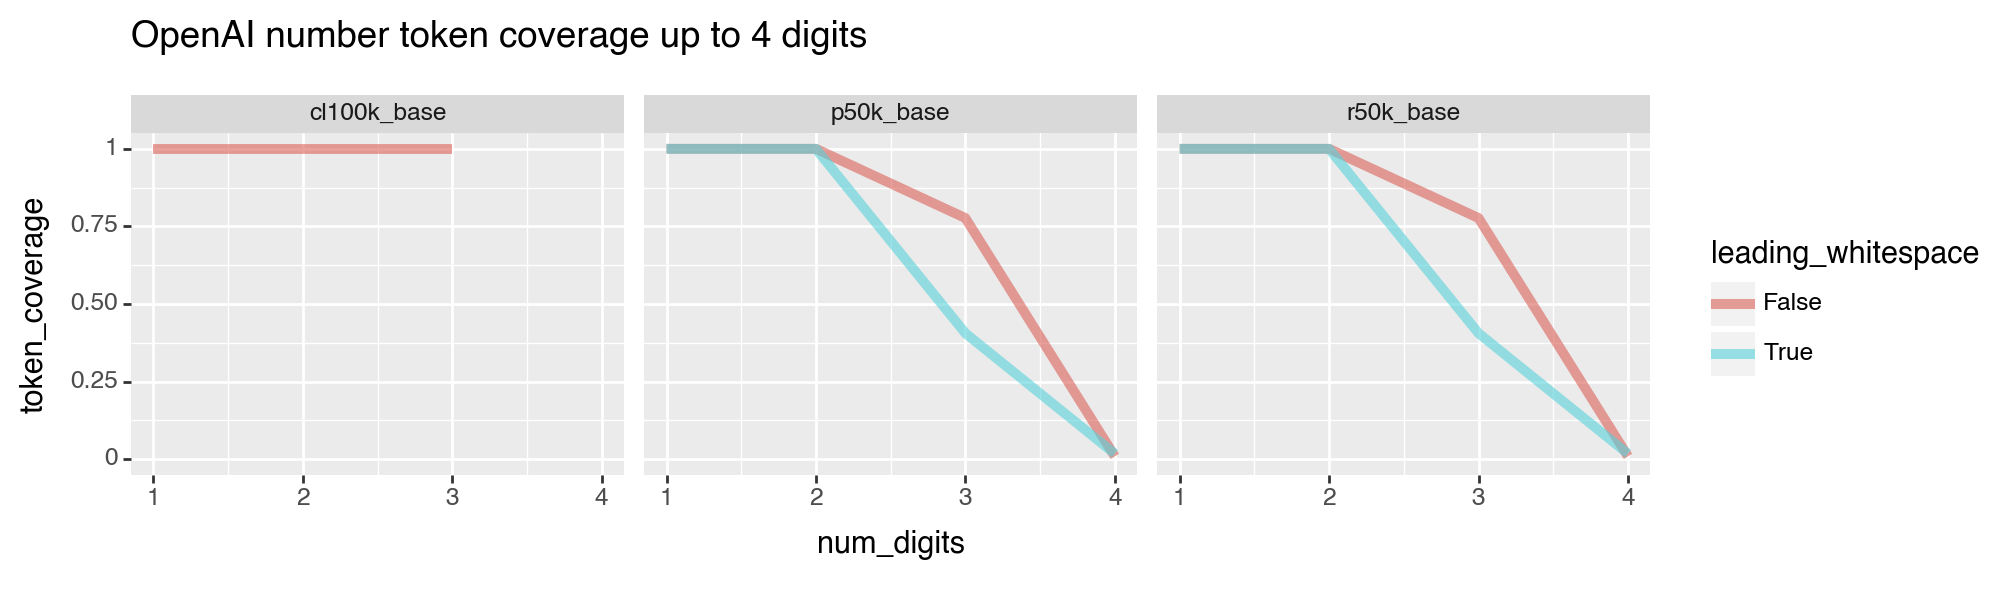

In [13]:
#@title Plot token coverage over tokenizers, digits, and with/without whitespace
max_digits = 4 # @param {'type': 'integer'}
plot = (gg.ggplot(df)
             + gg.aes(x='num_digits', y='token_coverage', colour='leading_whitespace',
                      group='leading_whitespace')
             + gg.geom_line(size=2, alpha=0.6)  # additional options
             + gg.facet_wrap('tokenizer')
             + gg.xlim(1, max_digits)
             + gg.theme(figure_size=(10, 3))
             + gg.ggtitle(f'OpenAI number token coverage up to {max_digits} digits')
             )

print(plot)

In [14]:
#@title Display token coverage as nicely formatted table.
df['token_coverage_str'] = df['token_coverage'].apply(lambda x: f"{100*x:.1f}")
df['token_coverage_str'] = df['num_tokens'].astype('str') + ' (' + df['token_coverage_str'] + '%)'
df.pivot(index='num_digits', columns=['tokenizer', 'leading_whitespace'], values='token_coverage_str').fillna('0 (0.0%)')

tokenizer              r50k_base                   p50k_base                 
leading_whitespace         False          True         False          True   
num_digits                                                                   
1                    10 (100.0%)   10 (100.0%)   10 (100.0%)   10 (100.0%)  \
2                   100 (100.0%)  100 (100.0%)  100 (100.0%)  100 (100.0%)   
3                    777 (77.7%)   406 (40.6%)   777 (77.7%)   406 (40.6%)   
4                      94 (0.9%)    178 (1.8%)     94 (0.9%)    178 (1.8%)   
5                       6 (0.0%)      1 (0.0%)      6 (0.0%)      1 (0.0%)   
6                       2 (0.0%)      1 (0.0%)      2 (0.0%)      1 (0.0%)   
7                       1 (0.0%)      0 (0.0%)      1 (0.0%)      0 (0.0%)   
8                       3 (0.0%)      1 (0.0%)      3 (0.0%)      1 (0.0%)   
16                      1 (0.0%)      0 (0.0%)      1 (0.0%)      0 (0.0%)   

tokenizer             cl100k_base  
leading_whitespace          False  
num_digits                         
1                     10 (100.0%)  
2                    100 (100.0%)  
3                   1000 (100.0%)  
4                        0 (0.0%)  
5                        0 (0.0%)  
6                        0 (0.0%)  
7                        0 (0.0%)  
8                        0 (0.0%)  
16                       0 (0.0%)

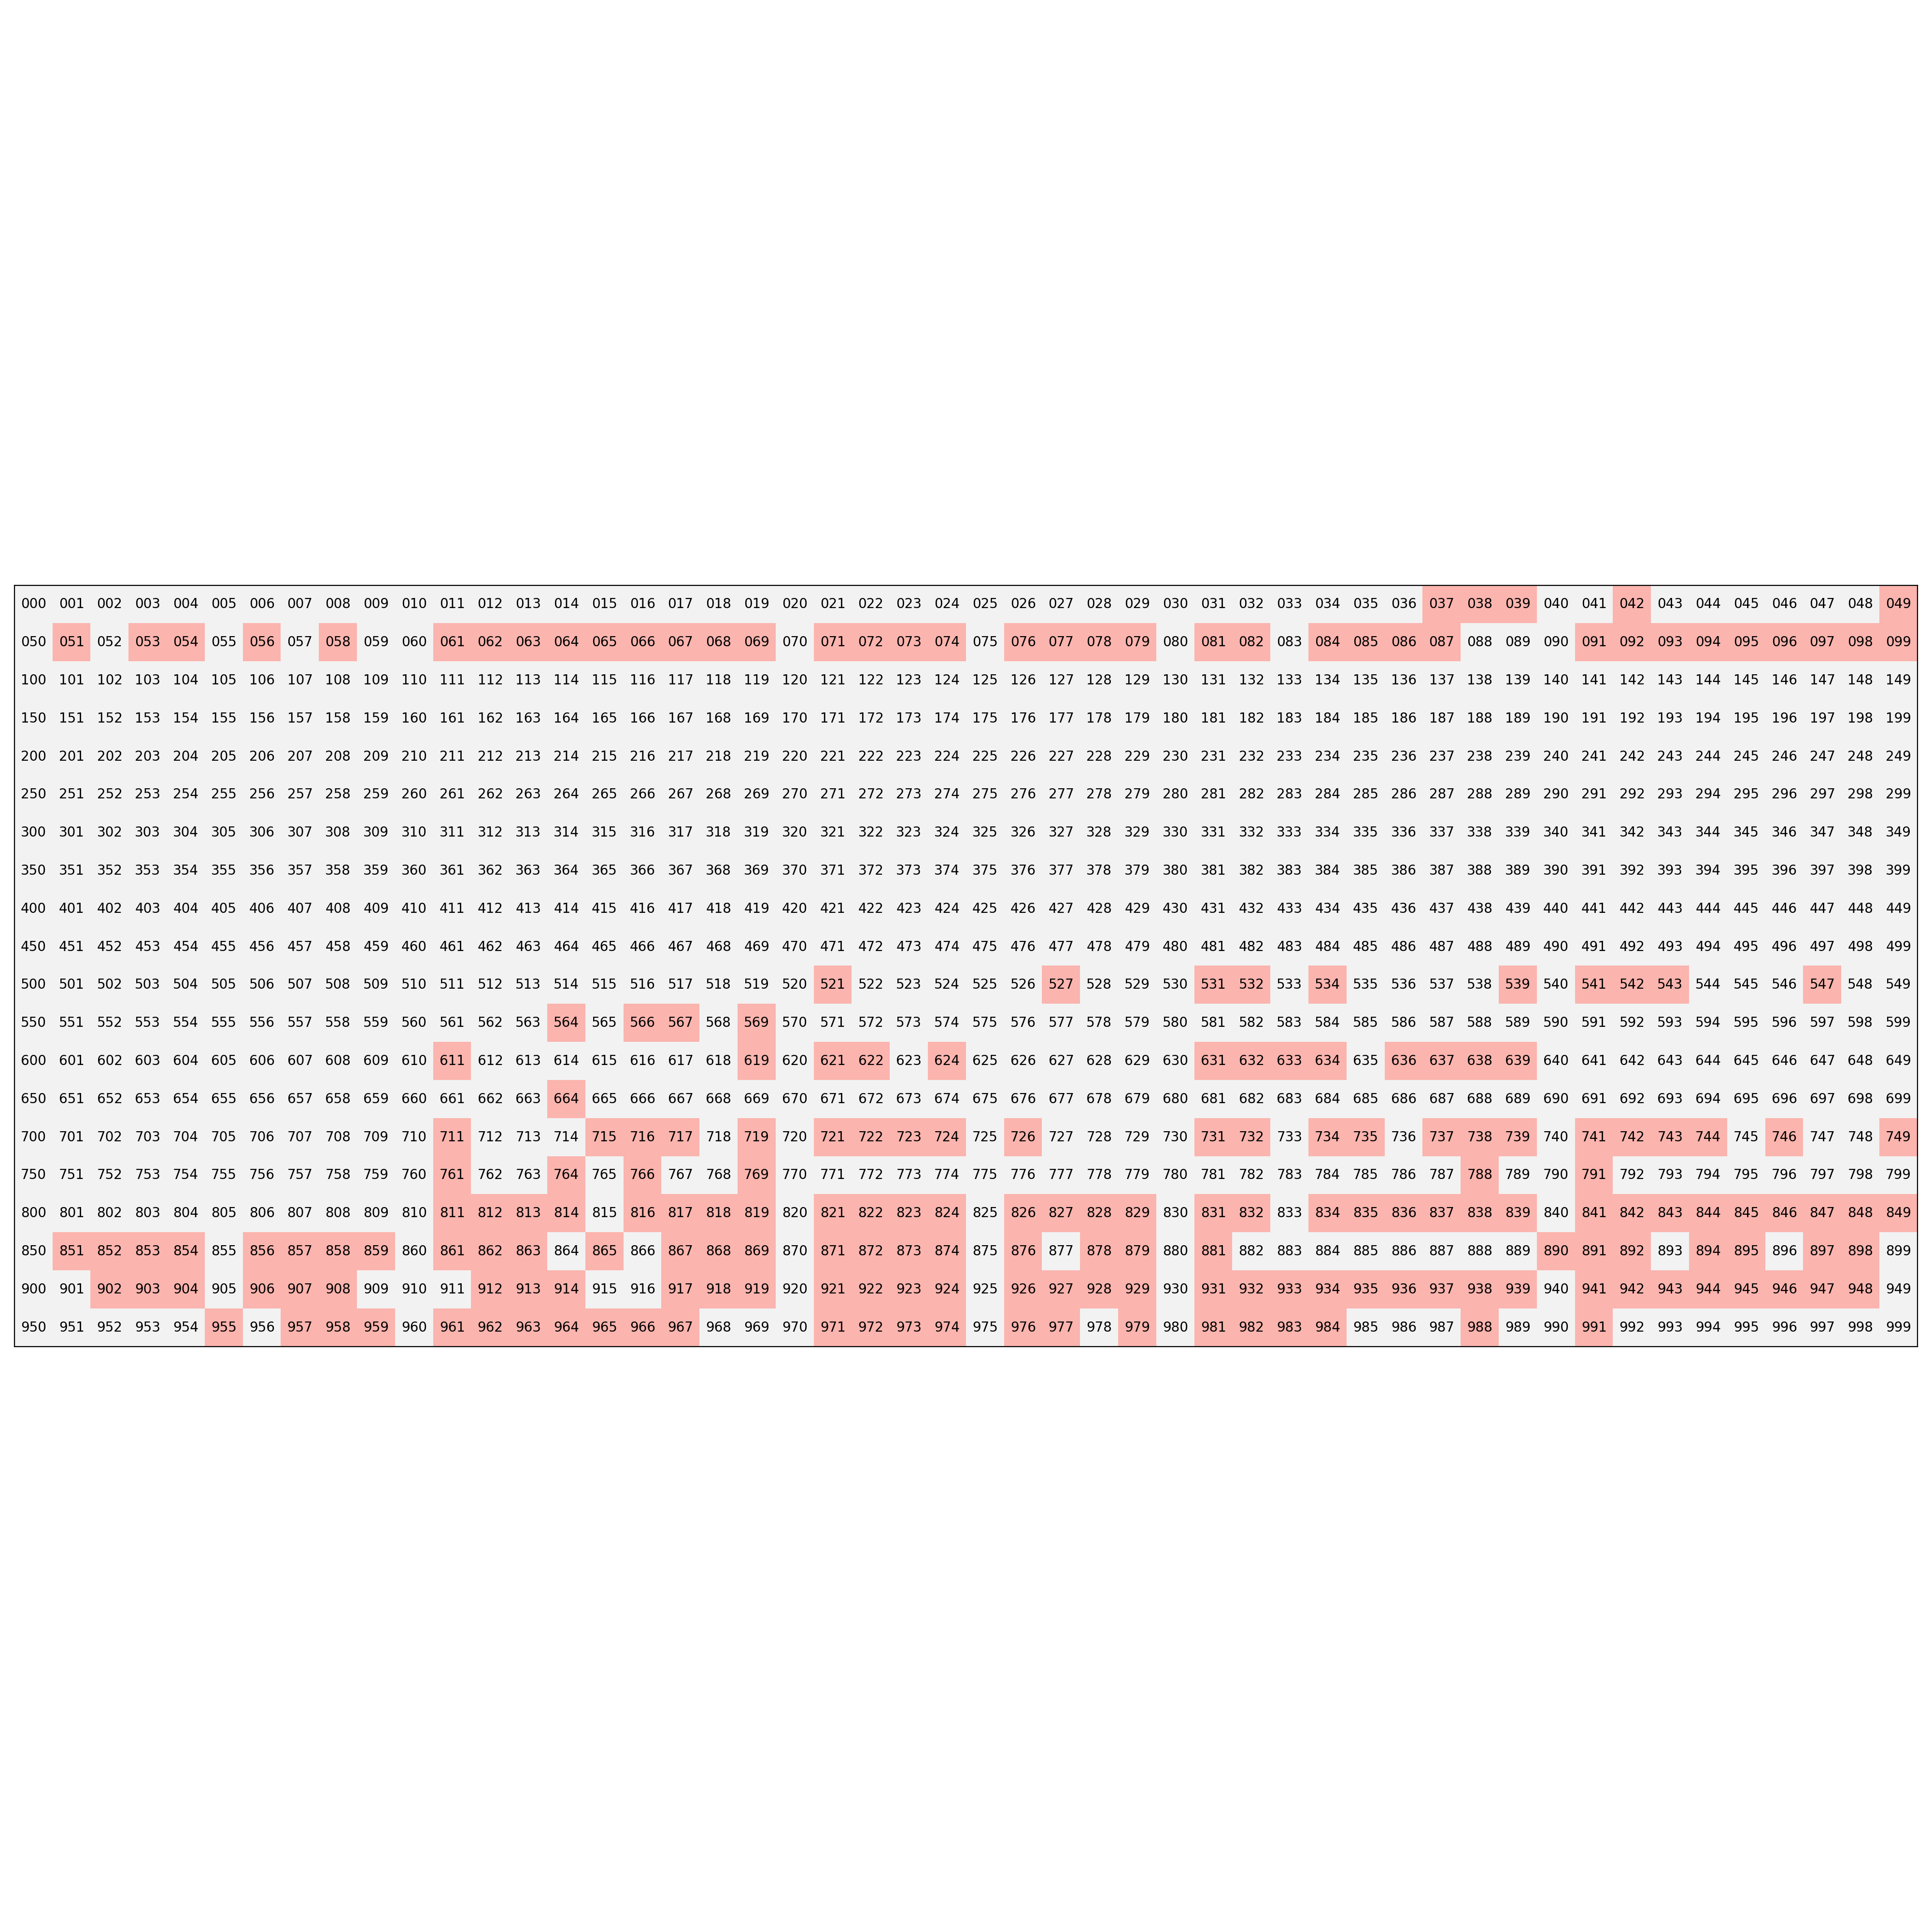

In [15]:
#@title Print a grid of all numbers, colored by whether or not they have a token.
save_fig = True
t = 'p50k_base'
num_digits = 3
ws = False
num_rows = 20
fig_size = (20, 20)

if 10**num_digits % num_rows > 0:
  raise ValueError(f'10^num_digits ({10**num_digits}) must be divisible by num_rows ({num_rows}).')
num_cols = int(10**num_digits / num_rows)

# gather data
is_token = [] # boolean
labels = [] # string rep of numbers
for i in range(10**num_digits):
  str_rep = str(i).zfill(num_digits)
  labels.append(str_rep)
  if ws:
    str_rep = ' ' + str_rep
  is_token.append(str_rep.encode('utf-8') in number_encs[t].keys())
is_token = np.reshape(is_token, (num_rows, num_cols))
labels = np.reshape(labels, (num_rows, num_cols))

# plot
fig = plt.figure(figsize=fig_size)
ax = plt.gca()
ax.matshow(is_token, cmap='Pastel1')
for (i, j), z in np.ndenumerate(labels):
    ax.text(j, i, '{}'.format(z), ha='center', va='center')
plt.xticks([])
plt.yticks([])
if not save_fig:
  if ws:
    plt.title('with leading whitespace')
  else:
    plt.title('no leading whitespace')
if save_fig:
  if ws:
    ws_str = 'with_ws'
  else:
    ws_str = 'no_ws'
  plt.savefig(f'figures/p50k_base_{num_digits}digit_{ws_str}_tokens_{num_rows}rows.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

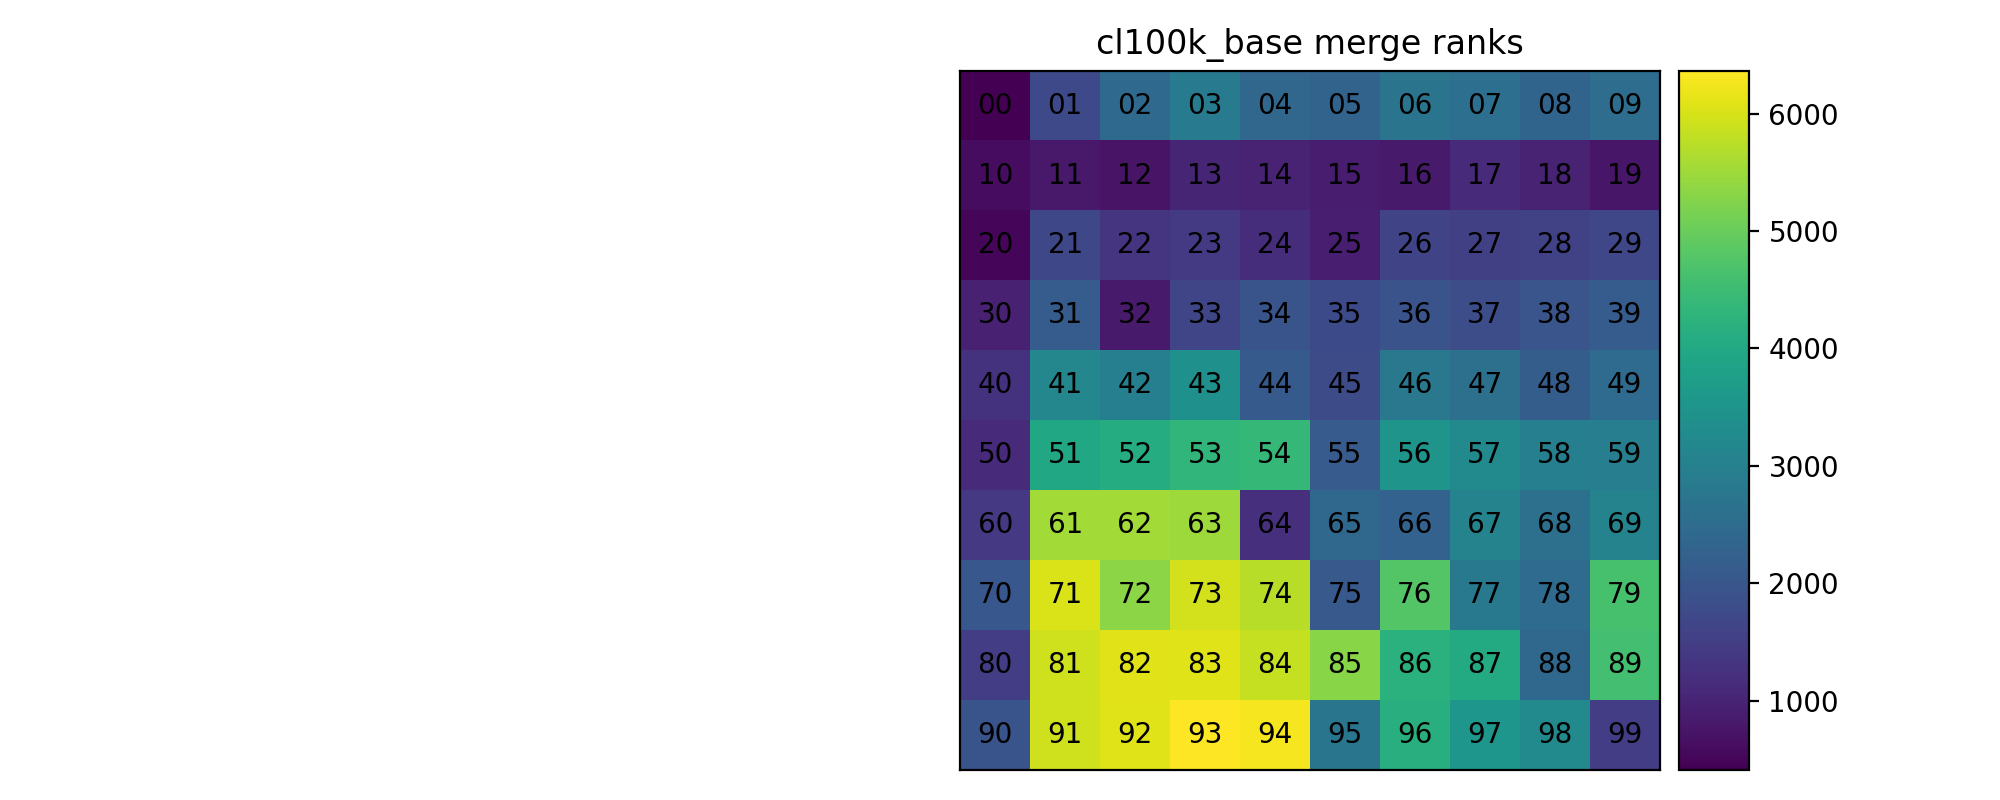

In [16]:
#@title Print a grid of all numbers, colored by merge rank.
t = 'cl100k_base'
num_digits = 2
ws = False
if num_digits == 2:
  num_rows = 10
  fig_size = (10, 4)
if num_digits == 3:
  num_rows = 50
  fig_size = (20, 20)

if 10**num_digits % num_rows > 0:
  raise ValueError(f'10^num_digits ({10**num_digits}) must be divisible by num_rows ({num_rows}).')
num_cols = int(10**num_digits / num_rows)

# gather data
ranks = [] # integer ranks
labels = [] # string rep of numbers
for i in range(10**num_digits):
  str_rep = str(i).zfill(num_digits)
  labels.append(str_rep)
  if ws:
    str_rep = ' ' + str_rep
  ranks.append(get_rank(str_rep,
                        tokenizer=t,
                        default=None))
ranks = np.reshape(ranks, (num_rows, num_cols))
labels = np.reshape(labels, (num_rows, num_cols))

# plot
fig = plt.figure(figsize=fig_size)
ax = plt.gca()
p = ax.matshow(ranks, cmap='viridis')
fig.colorbar(p, ax=ax, aspect=num_rows, pad=.01)
for (i, j), z in np.ndenumerate(labels):
    ax.text(j, i, '{}'.format(z), ha='center', va='center')
plt.xticks([])
plt.yticks([])
if ws:
  ws_str = 'with leading whitespace'
else:
  ws_str = 'no leading whitespace'
if t == 'cl100k_base':
  plt.title(f'{t} merge ranks')
else:
  plt.title(f'{t} merge ranks, {ws_str}')
plt.tight_layout()
plt.show()

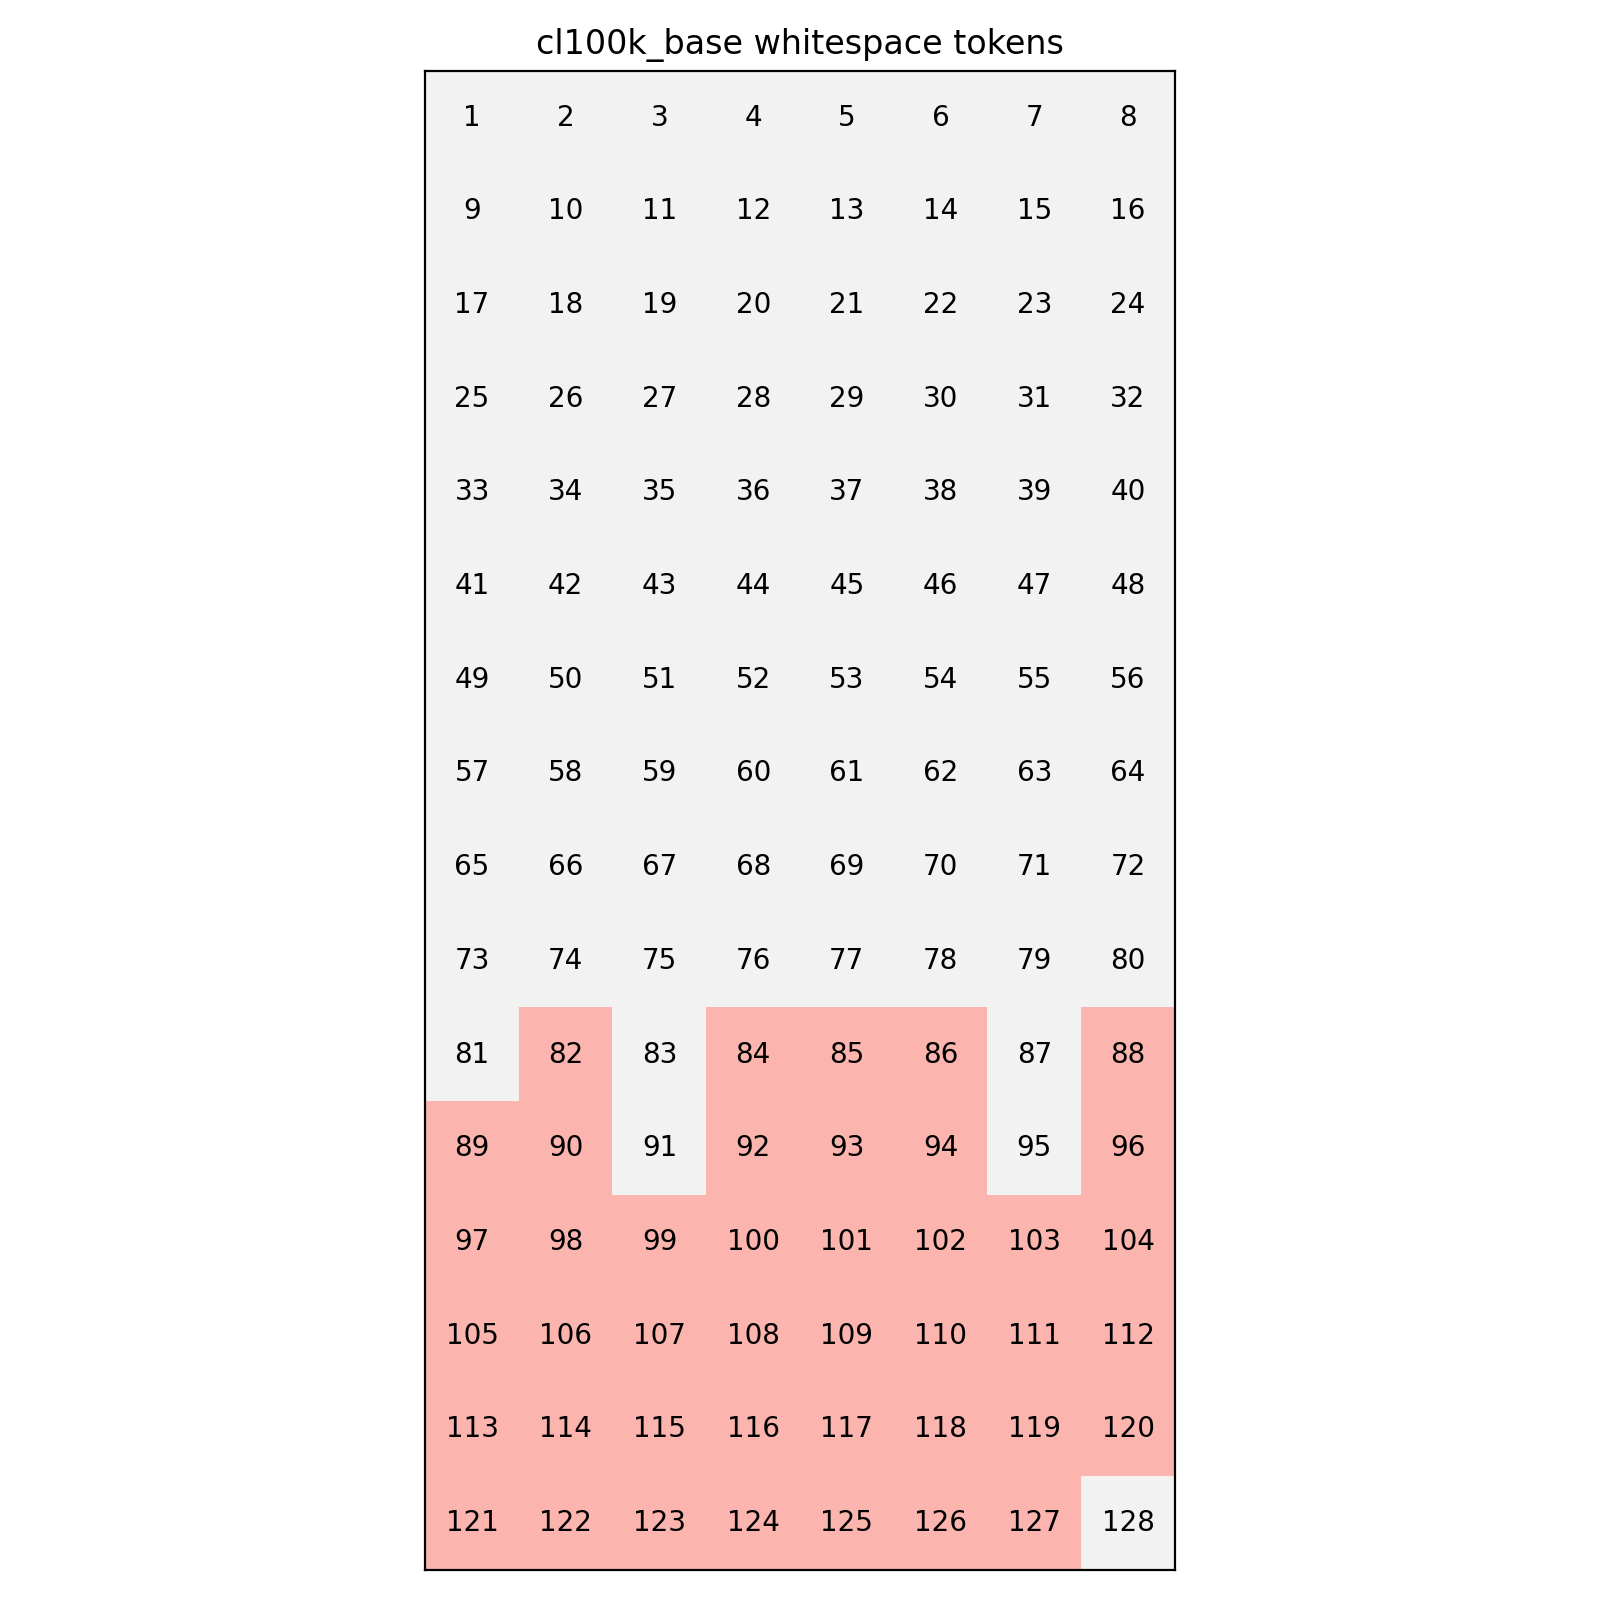

In [17]:
# Which numbers of consecutive whitespace do/do not have dedicated tokens?
k = 'cl100k_base'
max_spaces = 128
num_rows = 16
num_cols = int(max_spaces / num_rows)
fig_size = (8, 8)

enc = tiktoken.get_encoding(k)
is_token = []
labels = []
for i in range(1, max_spaces+1):
    labels.append(i)
    is_token.append(len(enc.encode(' '*i))==1)

is_token = np.reshape(is_token, (num_rows, num_cols))
labels = np.reshape(labels, (num_rows, num_cols))

# plot
fig = plt.figure(figsize=fig_size)
ax = plt.gca()
ax.matshow(is_token, cmap='Pastel1')
for (i, j), z in np.ndenumerate(labels):
    ax.text(j, i, '{}'.format(z), ha='center', va='center')
plt.xticks([])
plt.yticks([])
plt.title(f'{k} whitespace tokens')
plt.tight_layout()
plt.show()

In [18]:
#@title Build dataframe of tokenization counts.
min_digits = 1 #@param {'type': 'integer'}
max_digits = 4 #@param {'type': 'integer'}

start_time = timeit.default_timer()

df = pd.DataFrame(columns=['tokenizer', 'leading_whitespace', 'num_digits', 'num_tokens', 'count', 'fraction', 'total_count'])
for k in ['p50k_base', 'cl100k_base']:
  for n in range(min_digits, max_digits+1):
    for ws in [True, False]:
      num_tokens = []
      for i in range(10**n):
        str_rep = str(i).zfill(n)
        if ws:
          str_rep = ' ' + str_rep
        num_tokens.append(count_tokens(str_rep, k))
      unique_num_tokens, counts = np.unique(num_tokens, return_counts=True)
      tmp = pd.DataFrame({'tokenizer': k, 'leading_whitespace': ws, 'num_digits': n, 'num_tokens': unique_num_tokens, 'count': counts, 'total_count': int(10**n)})
      tmp['fraction'] = tmp['count'] / tmp['total_count']
      df = pd.concat([df, tmp], ignore_index=True)
df['count'] = df['count'].astype('int')
df['leading_whitespace'] = df['leading_whitespace'].astype('bool')
del df['total_count']

elapsed = timeit.default_timer() - start_time
print(f'That took {elapsed:.1f} seconds.')

print(df)

That took 0.2 seconds.
      tokenizer  leading_whitespace num_digits num_tokens  count  fraction
0     p50k_base                True          1          1     10    1.0000
1     p50k_base               False          1          1     10    1.0000
2     p50k_base                True          2          1    100    1.0000
3     p50k_base               False          2          1    100    1.0000
4     p50k_base                True          3          1    406    0.4060
5     p50k_base                True          3          2    594    0.5940
6     p50k_base               False          3          1    777    0.7770
7     p50k_base               False          3          2    223    0.2230
8     p50k_base                True          4          1    178    0.0178
9     p50k_base                True          4          2   9590    0.9590
10    p50k_base                True          4          3    232    0.0232
11    p50k_base               False          4          1     94    0.0094
12

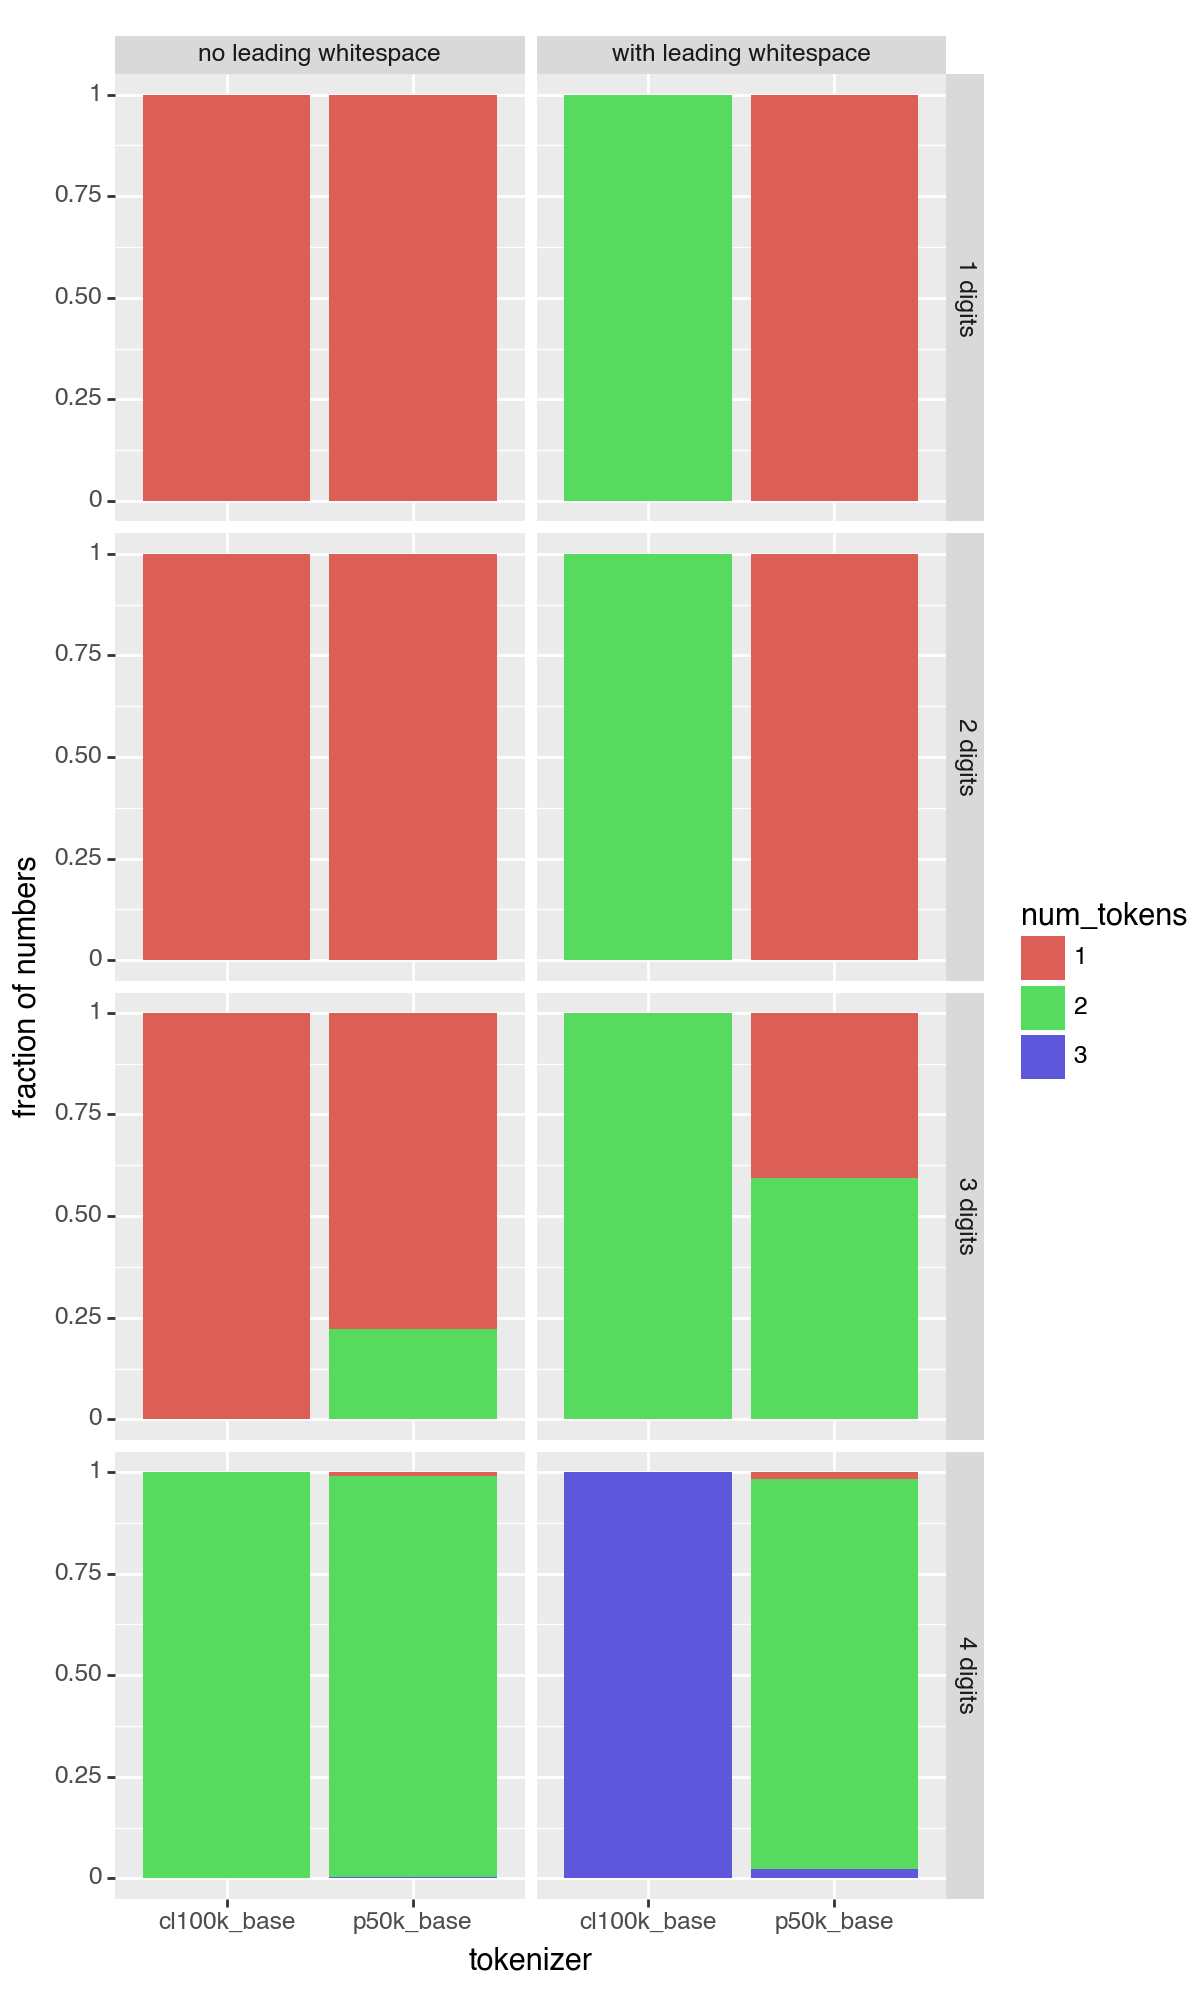

In [19]:
#@title Plot tokenization counts across tokenizers, number of digits, with and without whitespace.
lfunc = gg.facets.labelling.labeller(rows = lambda x: f'{x} digits',
                                     cols = lambda x: 'with leading whitespace' if x=='True' else 'no leading whitespace')
plot = (gg.ggplot(df)
             + gg.aes(x='tokenizer', y='fraction', fill='num_tokens')
             + gg.geom_col()  # additional options
             + gg.facet_grid('num_digits ~ leading_whitespace', labeller = lfunc)
             + gg.theme(figure_size=(6, 10))
             + gg.ylab('fraction of numbers')
            #  + gg.ggtitle('OpenAI number token coverage up to 4 digits')
             )
print(plot)

In [20]:
#@title Display token counts as nicely formatted table.
df['token_frac_str'] = df['fraction'].apply(lambda x: f"{100*x:.1f}")
df['token_count_str'] = df['count'].astype('int').astype('str') + ' (' + df['token_frac_str'] + '%)'

df.pivot(index=['num_digits', 'num_tokens'], columns=['tokenizer', 'leading_whitespace'], values='token_count_str').fillna('0 (0%)')

tokenizer                 p50k_base                   cl100k_base   
leading_whitespace            True          False           True    
num_digits num_tokens                                               
1          1            10 (100.0%)   10 (100.0%)          0 (0%)  \
           2                 0 (0%)        0 (0%)     10 (100.0%)   
2          1           100 (100.0%)  100 (100.0%)          0 (0%)   
           2                 0 (0%)        0 (0%)    100 (100.0%)   
3          1            406 (40.6%)   777 (77.7%)          0 (0%)   
           2            594 (59.4%)   223 (22.3%)   1000 (100.0%)   
4          1             178 (1.8%)     94 (0.9%)          0 (0%)   
           2           9590 (95.9%)  9876 (98.8%)          0 (0%)   
           3             232 (2.3%)     30 (0.3%)  10000 (100.0%)   

tokenizer                              
leading_whitespace              False  
num_digits num_tokens                  
1          1              10 (100.0%)  
           2                   0 (0%)  
2          1             100 (100.0%)  
           2                   0 (0%)  
3          1            1000 (100.0%)  
           2                   0 (0%)  
4          1                   0 (0%)  
           2           10000 (100.0%)  
           3                   0 (0%)

In [21]:
def token_partition_from_string(string: str, encoding_name: str) -> str:
    """Returns token partition for string. Works best for <=10 char."""
    encoding = tiktoken.get_encoding(encoding_name)
    encs = encoding.encode(string)
    decs = [encoding.decode([e]) for e in encs]
    lens = [len(d) for d in decs]
    p = ''
    i = 1
    for l in lens:
      p += '['+''.join(map(str, range(i,i+l)))+']'
      i += l
    return p

In [22]:
#@title Build dataframe of tokenization breakdowns.
min_digits = 1 #@param {'type': 'integer'}
max_digits = 4 #@param {'type': 'integer'}

start_time = timeit.default_timer()

df = pd.DataFrame(columns=['tokenizer', 'leading_whitespace', 'num_digits', 'partition', 'count', 'fraction', 'total_count'])
for k in ['p50k_base', 'cl100k_base']:
  for n in range(min_digits, max_digits+1):
    for ws in [True, False]:
      partitions = []
      for i in range(10**n):
        str_rep = str(i).zfill(n)
        if ws:
          str_rep = ' ' + str_rep
        partitions.append(token_partition_from_string(str_rep, k))
      unique_partitions, counts = np.unique(partitions, return_counts=True)
      tmp = pd.DataFrame({'tokenizer': k, 'leading_whitespace': ws, 'num_digits': n, 'partition': unique_partitions, 'count': counts, 'total_count': int(10**n)})
      tmp['fraction'] = tmp['count'] / tmp['total_count']
      df = pd.concat([df, tmp], ignore_index=True)
df['count'] = df['count'].astype('int')
df['leading_whitespace'] = df['leading_whitespace'].astype('bool')
del df['total_count']

elapsed = timeit.default_timer() - start_time
print(f'That took {elapsed:.1f} seconds.')

print(df)

That took 0.5 seconds.
      tokenizer  leading_whitespace num_digits    partition  count  fraction
0     p50k_base                True          1         [12]     10    1.0000
1     p50k_base               False          1          [1]     10    1.0000
2     p50k_base                True          2        [123]    100    1.0000
3     p50k_base               False          2         [12]    100    1.0000
4     p50k_base                True          3       [1234]    406    0.4060
5     p50k_base                True          3     [123][4]     44    0.0440
6     p50k_base                True          3     [12][34]    550    0.5500
7     p50k_base               False          3        [123]    777    0.7770
8     p50k_base               False          3      [12][3]     50    0.0500
9     p50k_base               False          3      [1][23]    173    0.1730
10    p50k_base                True          4      [12345]    178    0.0178
11    p50k_base                True          4    [12

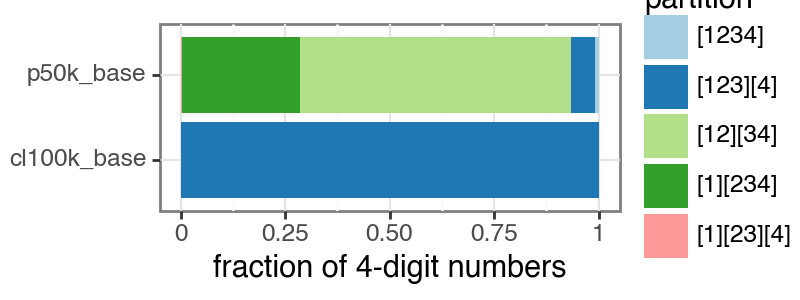


tokenizer      cl100k_base     p50k_base
partition                               
[1234]              0 (0%)     94 (0.9%)
[123][4]    10000 (100.0%)    559 (5.6%)
[12][34]            0 (0%)  6502 (65.0%)
[1][234]            0 (0%)  2815 (28.1%)
[1][23][4]          0 (0%)     30 (0.3%)


In [23]:
#@title Token partitions across tokenizers.
save_fig = False
num_digits = 4 #@param {'type': 'integer'}
leading_whitespace = False #@param {'type': 'boolean'}

colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99']
# colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0']

if leading_whitespace:
  ws = 'with'
else:
  ws = 'no'
plot = (gg.ggplot(df[(df['num_digits']==num_digits) & (df['leading_whitespace'] == leading_whitespace)])
             + gg.aes(x='tokenizer', y='fraction', fill='partition')
             + gg.geom_col()  # additional options
             + gg.coord_flip()
             + gg.theme_bw()
             + gg.theme(figure_size=(4, 1.5), axis_title_y = gg.element_blank())
             + gg.scale_fill_manual(values = colors)
             + gg.ylab(f'fraction of {num_digits}-digit numbers')
             )
print(plot)
if save_fig:
  plot.save('figures/p50k_base_4digit_nowhitespace_partitions.pdf')

# print nice table
tmp = df[(df['num_digits']==num_digits) & (df['leading_whitespace'] == leading_whitespace)].copy()
del tmp['num_digits'], tmp['leading_whitespace']
tmp['partition_frac_str'] = tmp['fraction'].apply(lambda x: f"{100*x:.1f}")
tmp['partition_count_str'] = tmp['count'].astype('int').astype('str') + ' (' + tmp['partition_frac_str'] + '%)'
print(tmp.pivot(index=['partition'], columns=['tokenizer'], values='partition_count_str').fillna('0 (0%)'))

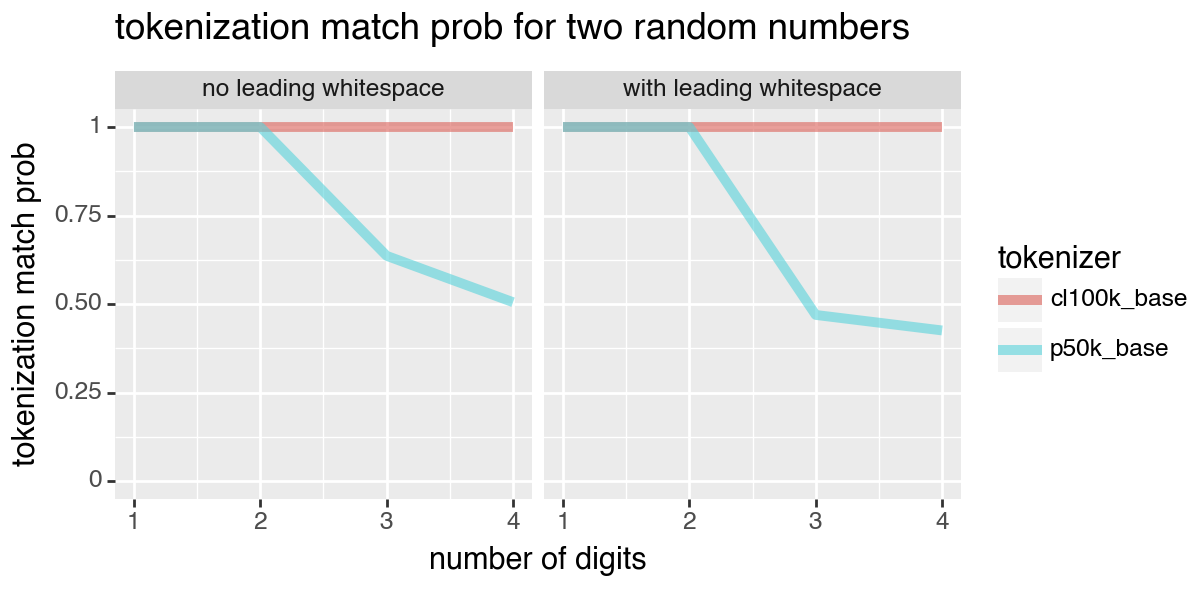


tokenizer          cl100k_base       p50k_base          
leading_whitespace       False True      False     True 
num_digits                                              
1                          1.0   1.0  1.000000  1.000000
2                          1.0   1.0  1.000000  1.000000
3                          1.0   1.0  0.636158  0.469272
4                          1.0   1.0  0.505224  0.425454


In [24]:
#@title Summarize above data as partition matching probability.
df_match = df.copy()
df_match['p2'] = df_match['fraction']**2
del df_match['partition']
del df_match['count']
del df_match['fraction']
df_match = df_match.groupby(['tokenizer', 'leading_whitespace', 'num_digits']).sum()
df_match['match_prob'] = df_match['p2']
del df_match['p2']
df_match = df_match.reset_index()

# plot
lfunc = gg.facets.labelling.labeller(cols = lambda x: 'with leading whitespace' if x=='True' else 'no leading whitespace')
plot = (gg.ggplot(df_match)
             + gg.aes(x='num_digits', y='match_prob', color='tokenizer')
             + gg.geom_line(size=2, alpha=0.6)  # additional options
             + gg.facet_grid('. ~ leading_whitespace', labeller=lfunc)
             + gg.theme(figure_size=(6, 3))
             + gg.ylim(0,1)
             + gg.ylab('tokenization match prob')
             + gg.xlab('number of digits')
             + gg.ggtitle('tokenization match prob for two random numbers')
             )
print(plot)

# print as table
print(df_match.pivot(index=['num_digits'], columns=['tokenizer', 'leading_whitespace'], values='match_prob').fillna(0))